# Import Section

In [1]:
# from audapter.driver.filter_driver import FilterDriver
from pyroomacoustics import adaptive

In [2]:
import numpy as np
from scipy.fft import rfft, irfft, rfftfreq, fft, ifft, fftfreq
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nptyping import Array

## import Virtual Error Source

In [3]:
from pysndfx import AudioEffectsChain

SOUND_FIELD = lambda x: 2. * x
# AEC = AudioEffectsChain()
# SOUND_FIELD = AEC.overdrive()

## import Warning Controller

In [4]:
from warnings import simplefilter
simplefilter('ignore')

# Define Global Variables

In [5]:
# Period
T_msec = 100

# Sample rate
fs = 44100
nyquist = fs//2

# Data size
N = fs * T_msec // 1000

# Filter Length
w_len = 10

# Maximum Amplifier
A_max = 256

# Amplifier
A = .8 * A_max

# Frequency of sound
w_sound = 440.

# Time
END_OF_TIME = 20
t = np.linspace(0, END_OF_TIME, fs*END_OF_TIME, dtype=np.float64)

## Make Arrays for Caching

In [6]:
x_cache = A * (np.sin(w_sound * (2 * np.pi * t)) + np.sin(w_sound * np.sqrt(2.) * (2 * np.pi * t ))) / 2.

d_cache = x_cache[:]

y_cache = np.zeros_like(t)

f_cache = np.zeros_like(y_cache)

w_cache = np.zeros((END_OF_TIME*1000//T_msec, w_len), dtype=np.float64)

# Main Section

## in First Step

In [54]:
# ## START_OF_THREAD ##
# x_now = x_cache[: N]
# # Output(FOR sound-field, FOR NOW, pass thru)
# y_now = x_now.copy()
# f_now = SOUND_FIELD(y_now[:])
# # Caching
# y_cache[: N] = y_now[:]
# f_cache[: N] = f_now[:]

## START_OF_THREAD ##
x_now = x_cache[:w_len]
# Output(FOR sound-field, FOR NOW, pass thru)
y_now = x_now[:]
f_now = SOUND_FIELD(y_now[:])
# Caching
y_cache[:w_len] = y_now
f_cache[:w_len] = f_now

## DOMAIN: TIME

In [55]:
# Filter
driver = adaptive.NLMS(length=w_len)
driver.w

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [70]:
blocksize = fs//2

for i in range(w_len, t.size):
    driver.update(d_cache[i-1], f_now)
    
    # Make input-array from 'x'
    x_indata = x_cache[i-w_len : i]

    y_cache[i] = np.dot(driver.w.T, x_indata)
    
    if i%blocksize == 0:
        f_cache[i-blocksize:i] = SOUND_FIELD(y_cache[i-blocksize:i])

In [71]:
# # Filter
# driver = FilterDriver(shape=w_len)

# w_cache[0] = driver.get_filter_weights()[:]

# for i in range(1, END_OF_TIME * 1000//T_msec):
    
#     ## START_OF_THREAD ##
    
#     # Desired signal IN PREV
#     d = d_cache[(i-1)*N  : i*N - w_len]
    
#     # Make input-array from 'f'
#     f_indata = np.array([f_cache[(i-1)*N+n : (i-1)*N+n + w_len] for n in range(N - w_len)])
    
#     # Filter weight matrix(in time)
#     w_new = driver.tune(desired=d, data_in=f_indata)
    
#     # Caching
#     w_cache[i] = w_new[:]
    
    
#     ## START_OF_THREAD ##
    
#     # Make input-array from 'x'
#     x_indata = np.array([x_cache[i*N+n : i*N+n + w_len] for n in range(N - w_len)])
    
#     # Get filter IN PREV
#     w_old = w_cache[(i-1)].reshape(1, -1)
    
#     # Output(FOR sound-field, FOR NOW)
#     y_now = np.dot(w_old, x_indata.T[::-1])
#     f_now = SOUND_FIELD(y_now[:]).reshape(1, -1)
#     # Caching
#     y_cache[i*N + w_len : (i+1)*N] = y_now[:]
#     f_cache[i*N + w_len : (i+1)*N] = f_now[:]

## DOMAIN: FREQ

In [72]:
from pyroomacoustics.transform import STFT, synthesis
from pyroomacoustics import windows

In [73]:
# blocksize = fs//2
# hop_len = blocksize//2

# stft_d = STFT(N=blocksize, hop=hop_len, analysis_window=windows.hann(blocksize))
# stft_f = STFT(N=blocksize, hop=hop_len, analysis_window=windows.hann(blocksize))

# driver = adaptive.SubbandLMS(num_taps=w_len, num_bands=hop_len+1, nlms=True)

In [74]:
# driver.X.shape

In [75]:
# # in First step
# y_now = x_cache[:hop_len]
# y_cache[:hop_len] = y_now
# f_cache[:hop_len] = SOUND_FIELD(y_now)

In [76]:
# def analyze_input_recursively(block, stft_obj):
#     stft_obj.analysis(block)
#     return stft_obj.X[:]

# for i in range(hop_len, t.size-hop_len, hop_len):
#     d_block = d_cache[i-hop_len:i]
#     f_block = f_cache[i-hop_len:i]
    
#     stft_d.analysis(d_block)
#     stft_f.analysis(f_block)
    
#     driver.update(stft_d.X, stft_f.X)
    
#     X_in = np.zeros_like(driver.X)
#     x_in = np.array([x_cache[i-n:i-n+hop_len] for n in range(w_len)])
#     X_in = np.array([analyze_input_recursively(x_, stft_d) for x_ in x_in])

#     Y_now = np.diag(np.dot(driver.W.conj().T, X_in))
#     y_now = stft_f.synthesis(Y_now)
#     f_now = SOUND_FIELD(y_now)
    
#     # Caching
#     y_cache[i : i+y_now.size] = y_now[:]
#     f_cache[i : i+f_now.size] = f_now[:]

In [77]:
# # splitting rate
# split_num = 100

# # STEP_SIZE = 1[sec]
# # FRAGMENT_SIZE
# N = fs

# # Frequency in freq. domain
# omega = rfftfreq(N, d=1./fs)

# # Filter
# DRIVERS = [FilterDriver(shape=w_len) for _ in range(omega.size//split_num+1)]

# # Make array for caching FILTER_WEIGHTS
# W_CACHE = np.zeros((END_OF_TIME, omega.size//split_num+1, w_len), dtype=np.float64)

# for i in range(1, END_OF_TIME):
#     ## START_OF_THREAD ##

#     # Desired signal IN PREV
#     d = np.array([d_cache[(i-1)*N + n*split_num : (i-1)*N + (n+1)*split_num] for n in range(N//split_num)])
#     if i == 1:
#         print(d.shape)

#     # Make input-array from 'f'
#     f = np.array([f_cache[(i-1)*N + n*split_num : (i-1)*N + (n+1)*split_num] for n in range(N//split_num)])
#     if i == 1:
#         print(f.shape)

#     # FFT
#     D = np.abs(rfft(d, axis=0)) / N/split_num
#     F = rfft(f, axis=0) / N/split_num
#     if i == 1:
#         print(D.shape)

#     # Make input-array from 'F'
#     F_IN = np.array([F[:, n : n+w_len] for n in range(split_num - w_len)])[::-1]
#     if i == 1:
#         print(F_IN.shape)

#     # Filter weight matrix(IN FREQ)
#     W_NEW = np.array([driver.tune(desired=D[w, -(split_num-w_len):], data_in=F_IN[:, w]) for w, driver in enumerate(DRIVERS)])
#     if i == 1:
#         print(W_NEW.shape)

#     # Caching
#     W_CACHE[i] = W_NEW[:]


#     ## START_OF_THREAD ##

#     # Input signal FOR NOW
#     x = np.array([x_cache[i*N + n*split_num : i*N + (n+1)*split_num] for n in range(N//split_num)])

#     # FFT
#     X = rfft(x, axis=0) / N/split_num
#     # Make input-array from 'X'
#     X_IN = np.array([X[:, n : n+w_len] for n in range(split_num - w_len)])[::-1]

#     # Get filter IN PREV
#     W_OLD = W_CACHE[i-1]

#     # Output(FOR sound-field, FOR NOW)
#     Y_NOW = np.array([np.dot(W_OLD[w], X_IN[:, w].T) for w in range(X_IN.shape[1])])
#     if i == 1:
#         print(Y_NOW.shape)
    
#     y_now = irfft(Y_NOW, axis=0).reshape(-1)
#     if i == 1:
#         print(y_now.shape)
#     f_now = SOUND_FIELD(y_now[:]).astype(np.float64)
#     # Caching
#     y_cache[(i+1)*N - len(y_now) : (i+1)*N] = y_now[:]
#     f_cache[(i+1)*N - len(f_now) : (i+1)*N] = f_now[:]

# Plot Result

In [78]:
tail = t.size//1000

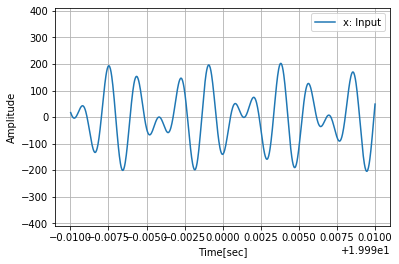

In [79]:
plt.plot(t[-tail:], x_cache[-tail:], label="x: Input")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
plt.grid()
plt.show()

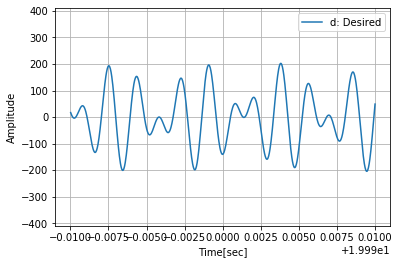

In [80]:
plt.plot(t[-tail:], d_cache[-tail:], label="d: Desired")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
plt.grid()
plt.show()

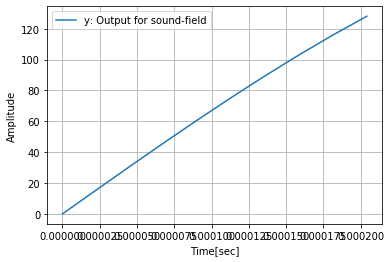

In [81]:
# plt.plot(t[-tail:], y_cache[-tail:], label="y: Output for sound-field")
plt.plot(t, y_cache, label="y: Output for sound-field")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
# plt.ylim([-2.*A, 2.*A])
plt.legend()
plt.grid()
plt.show()

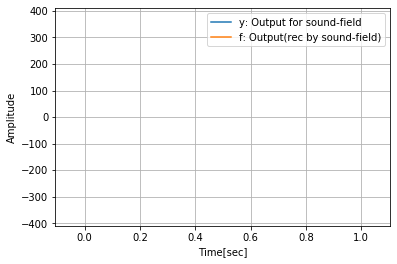

In [82]:
plt.plot(t[-tail:], y_cache[-tail:], label="y: Output for sound-field")
plt.plot(t[-tail:], f_cache[-tail:], label="f: Output(rec by sound-field)")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
plt.grid()
plt.show()

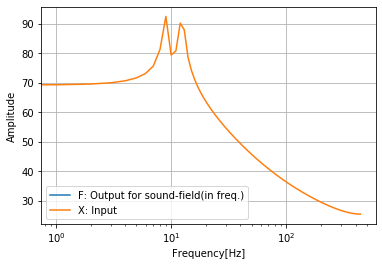

In [39]:
plt.plot(20*np.log10(rfft(f_cache[-tail:])), label="F: Output for sound-field(in freq.)")
plt.plot(20*np.log10(rfft(x_cache[-tail:])), label="X: Input")
plt.xlabel("Frequency[Hz]")
plt.ylabel("Amplitude")
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()